In [4]:
%matplotlib inline
from pycocotools.coco import COCO
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import os
import pylab
import skimage.io as io
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
# Directories for the images and the annotations
images_dir = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/val2017'
anns_dir = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/annotations/instances_val2017.json'

In [6]:
# Load the annotations for the whole dataset
coco = COCO(anns_dir)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [7]:
# Get image IDs and corresponding annotations for validation set
image_ids = coco.getImgIds()
annotations = coco.loadAnns(coco.getAnnIds(image_ids))

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Split the data into training and validation sets
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

In [9]:
def padding(image, target_shape):
    # Calculate the target size for resizing while maintaining aspect ratio
    height, width, _ = image.shape
    target_width, target_height = target_shape
    aspect_ratio = width / height

    if aspect_ratio > 1:  # Landscape image
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:  # Portrait image
        new_height = target_height
        new_width = int(new_height * aspect_ratio)

    # Resize the image while maintaining aspect ratio
    resized_image = cv2.resize(image, (new_width, new_height))

    # Create an empty canvas with the target shape
    canvas = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    # Calculate the position to paste the resized image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image

    return canvas


def preprocess_images(coco, image_ids, images_dir, output_dir, target_shape):
    for img_id in tqdm(image_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(images_dir, img_info['file_name'])
        image = cv2.imread(img_path)

        # Resize image while maintaining aspect ratio and adding padding
        padded_image = padding(image, target_shape)

        # Normalize pixel values to be in the range [0, 1]
        padded_image = padded_image / 255.0

        # Save processed image
        output_path = os.path.join(output_dir, f"{img_id}.jpg")
        cv2.imwrite(output_path, (padded_image * 255).astype(np.uint8))

In [10]:
# Making directories for the processed images for each set
train_images_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/images/train"
os.makedirs(train_images_dir, exist_ok=True)

val_images_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/images/val"
os.makedirs(val_images_dir, exist_ok=True)

test_images_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/images/test"
os.makedirs(test_images_dir, exist_ok=True)

In [11]:
# Target shape for the processing:
target_shape = (416, 416)

In [40]:
# Preprocessing the images for each set
preprocess_images(coco, train_ids, images_dir, train_images_dir, target_shape)
preprocess_images(coco, val_ids, images_dir, val_images_dir, target_shape)
preprocess_images(coco, test_ids, images_dir, test_images_dir, target_shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.78it/s]


In [12]:
def load_image_set(image_ids, image_dir, coco):
    img_set = []
    
    for img_id in tqdm(image_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        img_set.append(image)
        
    return img_set

In [25]:
coco.loadImgs(train_ids[0])[0]

{'license': 2,
 'file_name': '000000078748.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000078748.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-14 14:42:28',
 'flickr_url': 'http://farm2.staticflickr.com/1072/821953154_8e5312ce36_z.jpg',
 'id': 78748}

In [9]:
# Loading the images for each set
train_images = load_image_set(train_ids, train_images_dir, coco)
val_images = load_image_set(val_ids, val_images_dir, coco)
test_images = load_image_set(test_ids, test_images_dir, coco)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 221.97it/s]


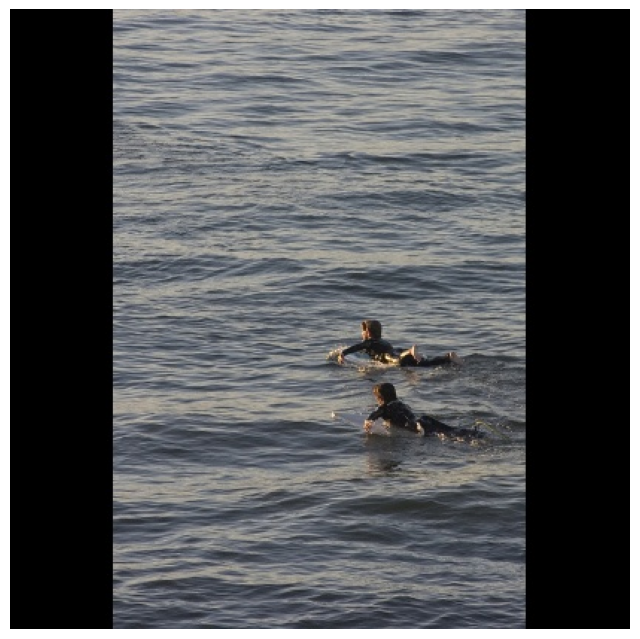

In [10]:
# Display one image using matplotlib
plt.imshow(cv2.cvtColor(train_images[7], cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

In [34]:
def process_bbox(annotation):
    # image dimensions
    img_info = coco.loadImgs(annotation['image_id'])[0]
    img_width = img_info['width']
    img_height = img_info['height']

    # Original bounding box coordinates
    x, y, width, height = (
        annotation['bbox'][0],
        annotation['bbox'][1],
        annotation['bbox'][2],
        annotation['bbox'][3],
    )

    # Finding midpoints
    center_x = (x + (x + width)) / 2
    center_y = (y + (y + height)) / 2
    
    # Normalizing to YOLO format
    center_x = center_x / img_width
    center_y = center_y / img_height
    n_width = width / img_width
    n_height = height / img_height

    # Limiting to a fixed number of decimals
    center_x = format(center_x, '.6f')
    center_y = format(center_y, '.6f')
    n_width = format(n_width, '.6f')
    n_height = format(n_height, '.6f')
    
    processed_bbox = center_x, center_y, width, height
    
    return processed_bbox

In [29]:
def yolo_annotations(image_id, annotations):
    anns = [annotation for annotation in annotations if annotation['image_id'] == image_id]
    labels = []
    
    for ann in anns:
        bbox = process_bbox(ann)
        label = f"{ann['category_id'] - 1}, {bbox[0]}, {bbox[1]}, {bbox[2]}, {bbox[3]}"
        labels.append(label)
    
    return labels


def save_yolo_annotations(image_id, yolo_annotations, save_dir):
    save_path = os.path.join(save_dir, f"{image_id}.txt")

    with open(save_path, 'w') as file:
        for annotation in yolo_annotations:
            file.write(annotation + '\n')


def make_yolo_annotations_set(image_ids, annotations, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    for img_id in tqdm(image_ids):
        yolo_anns = yolo_annotations(img_id, annotations)

        # Save YOLO annotations for each image
        save_yolo_annotations(img_id, yolo_anns, save_dir)

In [28]:
# Directories for the processed annotations
train_anns_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/annotations/train"
os.makedirs(train_anns_dir, exist_ok=True)

val_anns_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/annotations/val"
os.makedirs(val_anns_dir, exist_ok=True)

test_anns_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/annotations/test"
os.makedirs(test_anns_dir, exist_ok=True)

In [19]:
grid_size = 13

In [16]:
# Load annotations for each set
train_anns = coco.loadAnns(coco.getAnnIds(train_ids))
test_anns = coco.loadAnns(coco.getAnnIds(test_ids))
val_anns = coco.loadAnns(coco.getAnnIds(val_ids))

In [17]:
train_anns

[{'segmentation': [[326.83,
    257.8,
    346.25,
    257.8,
    328.99,
    284.76,
    343.01,
    269.66,
    339.78,
    299.87,
    358.11,
    268.58,
    368.9,
    268.58,
    396.94,
    283.69,
    421.75,
    281.53,
    434.7,
    270.74,
    444.4,
    253.48,
    443.33,
    242.7,
    443.33,
    229.75,
    443.33,
    216.81,
    443.33,
    204.94,
    447.64,
    197.39,
    448.72,
    189.84,
    450.88,
    177.98,
    447.64,
    171.51,
    440.09,
    168.27,
    434.7,
    168.27,
    416.36,
    168.27,
    393.71,
    166.11,
    369.98,
    167.19,
    357.03,
    167.19,
    338.7,
    167.19,
    327.91,
    165.03,
    308.49,
    161.8,
    291.24,
    156.4,
    277.21,
    153.17,
    249.17,
    141.3,
    249.17,
    152.09,
    254.56,
    154.25,
    248.09,
    161.8,
    241.62,
    177.98,
    250.25,
    183.37,
    250.25,
    194.16,
    245.93,
    203.87,
    241.62,
    213.57,
    235.15,
    220.04,
    229.75,
    224.36,
    207.1,
 

In [35]:
make_yolo_annotations_set(train_ids, annotations, train_anns_dir)
make_yolo_annotations_set(val_ids, annotations, val_anns_dir)
make_yolo_annotations_set(test_ids, annotations, test_anns_dir)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.24it/s]


In [40]:
def rename_images(images_dir, image_ids):
    for id in tqdm(image_ids):
        current_filename = coco.loadImgs(id)[0]['file_name']
        old_file_path = os.path.join(images_dir, current_filename)
        new_file_path = os.path.join(images_dir, f'{id}.jpg')
        try:
            os.rename(old_file_path, new_file_path)
        except FileNotFoundError:
            print(f"File '{old_name}' not found in '{folder_path}'.")

In [41]:
rename_images(images_dir, image_ids)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2856.78it/s]


In [17]:
# Get the number of classes
categories = coco.loadCats(coco.getCatIds())

cat_ids = []

for cat in categories:
    cat_ids.append(cat['id'])
    
num_classes = max(cat_ids)
num_classes

90

In [19]:
def yolo_target_labels(annotations, grid_size, num_classes):
    target_labels = []

    for annotation in annotations:
        class_id = annotation['category_id']
        bbox = yolo_bbox(process_bbox(annotation), grid_size)
        x, y, width, height = bbox

        # Create the target label
        target_label = [
            0,  # Objectness score (1 for object presence, 0 for no object)
            x,
            y,
            width,
            height,
        ]

        # Class probabilities
        class_probabilities = np.zeros(num_classes)
        class_probabilities[class_id - 1] = 1  # Set the class probability for the specific class_id
        target_label.extend(class_probabilities)

        # Check if the object is present in the current grid cell
        grid_x = int(x * grid_size)
        grid_y = int(y * grid_size)
        if grid_x == int(x * grid_size) and grid_y == int(y * grid_size):
            target_label[0] = 1  # Set objectness score to 1

        target_labels.append(target_label)

    return target_labels


In [21]:
# Process annotations to get target labels for each set
grid_size = 13
train_T_labels = yolo_target_labels( train_anns, 13, num_classes)
test_T_labels = yolo_target_labels(test_anns, 13, num_classes)
val_T_labels = yolo_target_labels(val_anns, 13, num_classes)


In [201]:
# Create a new list to store expanded samples
expanded_samples = []

for i, (image_filename, annotation) in enumerate(zip(image_filenames, annotations)):
    # Process the annotation and create target labels
    target_labels = yolo_target_labels([annotation], grid_size, num_classes)

    # Create a duplicate entry for each annotation
    for label in target_labels:
        expanded_samples.append({
            'image_filename': image_filename,
            'target_label': label,
        })

NameError: name 'image_filenames' is not defined

In [215]:
def data_generator(img_samples, target_labels, batch_size):
    num_samples = len(img_samples)
    indices = np.arange(num_samples)

    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_samples = [img_samples[idx] for idx in batch_indices]
            batch_labels = [target_labels[idx] for idx in batch_indices]

            # Print shapes for debugging
            print("Batch Samples Shape:", np.array(batch_samples).shape)
            print("Batch Labels Shape:", np.array(batch_labels).shape)

            yield np.array(batch_samples), np.array(batch_labels)

In [196]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def convolutional_block(x, filters, size, strides=(1, 1)):
    x = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(x, filters):
    short_cut = x
    x = convolutional_block(x, filters // 2, 1)
    x = convolutional_block(x, filters // 2, 3)
    short_cut = convolutional_block(short_cut, filters // 2, 1)
    x = layers.Add()([short_cut, x])
    return x

def yolo_v3(input_size, num_classes, num_anchors):
    input_image = layers.Input(shape=(input_size, input_size, 3))

    x = convolutional_block(input_image, 32, 3)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = convolutional_block(x, 64, 3)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    for _ in range(2):
        x = residual_block(x, 64)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    for _ in range(4):
        x = residual_block(x, 128)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    for _ in range(4):
        x = residual_block(x, 256)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    for _ in range(4):
        x = residual_block(x, 512)

    for _ in range(2):
        x = residual_block(x, 1024)

    # Adjust the number of output channels based on the number of anchors and classes
    output_channels = num_anchors * (4 + 1 + num_classes)
    output = layers.Conv2D(output_channels, 1, activation='sigmoid')(x)

    model = Model(inputs=input_image, outputs=output)
    return model


In [264]:
import tensorflow as tf
from keras import backend as K

def yolo_loss(grid_size, num_boxes, num_classes):
    def loss_function(y_true, y_pred):
        # Extract components from predictions and targets
        true_objectness = y_true[..., 4]  # Binary indicator for object presence
        pred_objectness = y_pred[..., 4]

        true_box = y_true[..., :4]  # Ground truth bounding box coordinates
        pred_box = y_pred[..., :4]

        true_class = y_true[..., 5:]  # Ground truth class probabilities
        true_class = tf.cast(true_class, dtype=tf.uint8)
        true_class = tf.one_hot(true_class, num_classes)
        pred_class = y_pred[..., 5:]

        # Compute individual loss components
        objectness_loss = tf.keras.losses.BinaryCrossentropy()(true_objectness, pred_objectness)
        box_loss = tf.keras.losses.MeanSquaredError()(true_objectness * true_box, true_objectness * pred_box)
        class_loss = tf.keras.losses.CategoricalCrossentropy()(true_class, pred_class)

        # Combine the losses with appropriate weights
        total_loss = objectness_loss + 5.0 * box_loss + 2.0 * class_loss

        return total_loss

    return loss_function


In [198]:
input_size = target_shape[0]
num_anchors = 5

In [205]:
yolo_model = yolo_v3(input_size, num_classes, 5)

In [208]:
yolo_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d_255 (Conv2D)         (None, 416, 416, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_250 (B  (None, 416, 416, 32)         128       ['conv2d_255[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_250 (LeakyReLU  (None, 416, 416, 32)         0         ['batch_normalization_25

                                                                                                  
 conv2d_263 (Conv2D)         (None, 52, 52, 64)           2048      ['max_pooling2d_27[0][0]']    
                                                                                                  
 batch_normalization_258 (B  (None, 52, 52, 64)           256       ['conv2d_263[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_258 (LeakyReLU  (None, 52, 52, 64)           0         ['batch_normalization_258[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_265 (Conv2D)         (None, 52, 52, 64)           2048      ['max_pooling2d_27[0][0]']    
          

                                                                                                  
 batch_normalization_267 (B  (None, 52, 52, 64)           256       ['conv2d_272[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_267 (LeakyReLU  (None, 52, 52, 64)           0         ['batch_normalization_267[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_274 (Conv2D)         (None, 52, 52, 64)           4096      ['add_84[0][0]']              
                                                                                                  
 conv2d_273 (Conv2D)         (None, 52, 52, 64)           36864     ['leaky_re_lu_267[0][0]']     
          

 conv2d_281 (Conv2D)         (None, 26, 26, 128)          16384     ['add_87[0][0]']              
                                                                                                  
 batch_normalization_276 (B  (None, 26, 26, 128)          512       ['conv2d_281[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_276 (LeakyReLU  (None, 26, 26, 128)          0         ['batch_normalization_276[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_283 (Conv2D)         (None, 26, 26, 128)          16384     ['add_87[0][0]']              
                                                                                                  
 conv2d_28

                                                                                                  
 conv2d_290 (Conv2D)         (None, 13, 13, 256)          65536     ['add_90[0][0]']              
                                                                                                  
 batch_normalization_285 (B  (None, 13, 13, 256)          1024      ['conv2d_290[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_285 (LeakyReLU  (None, 13, 13, 256)          0         ['batch_normalization_285[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_292 (Conv2D)         (None, 13, 13, 256)          65536     ['add_90[0][0]']              
          

                                                                                                  
 batch_normalization_294 (B  (None, 13, 13, 512)          2048      ['conv2d_299[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_294 (LeakyReLU  (None, 13, 13, 512)          0         ['batch_normalization_294[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_301 (Conv2D)         (None, 13, 13, 512)          131072    ['add_93[0][0]']              
                                                                                                  
 conv2d_300 (Conv2D)         (None, 13, 13, 512)          2359296   ['leaky_re_lu_294[0][0]']     
          

In [255]:
# Create data generators for training, testing, and validation sets
batch_size = 32

def data_generator(img_samples, target_labels, batch_size):
    num_samples = len(img_samples)
    indices = np.arange(num_samples)
    
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_samples = [img_samples[idx] for idx in batch_indices]
            batch_labels = [target_labels[idx] for idx in batch_indices]
            
            # Print shapes for debugging
            print("Batch Samples Shape:", np.array(batch_samples).shape)
            print("Batch Labels Shape:", np.array(batch_labels).shape)

            yield np.array(batch_samples), np.array(batch_labels)

# Create data generators for each set
train_data_generator = data_generator(train_images, train_T_labels, batch_size)
test_data_generator = data_generator(test_images, test_T_labels, batch_size)
val_data_generator = data_generator(val_images, val_T_labels, batch_size)

# Train the model
yolo_model.fit(
    x=train_data_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=val_data_generator,
    validation_steps=len(val_images) // batch_size
)


Batch Samples Shape: (32, 416, 416, 3)
Batch Labels Shape: (32, 95)
Epoch 1/10


ValueError: in user code:

    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Mohamed Habib\AppData\Local\Temp\ipykernel_7924\1039793597.py", line 19, in loss_function  *
        class_loss = tf.keras.losses.CategoricalCrossentropy()(true_class, pred_class)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__  **
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, None, None, 420) are incompatible


In [267]:
train_T_labels = np.array(train_T_labels)
test_T_labels = np.array(test_T_labels)
val_T_labels = np.array(val_T_labels)

print("Shape before reshape:", train_T_labels.shape)
print("Size before reshape:", train_T_labels.size)

# Now you can reshape them
train_T_labels = train_T_labels.reshape((32, 13, 13, 95))
test_T_labels = test_T_labels.reshape((32, 13, 13, 95))
val_T_labels = val_T_labels.reshape((32, 13, 13, 95))

Shape before reshape: (23016, 95)
Size before reshape: 2186520


ValueError: cannot reshape array of size 2186520 into shape (32,416,416,95)

In [260]:
len(train_T_labels)

23016

In [265]:
yolo_model.compile(optimizer='adam', loss=yolo_loss(grid_size, num_anchors, num_classes))  # Adjust the loss function based on your task

# Train the model
batch_size = 32
num_epochs = 10

# Create data generators for each set
train_data_generator = data_generator(train_images, train_T_labels, batch_size)
test_data_generator = data_generator(test_images, test_T_labels, batch_size)
val_data_generator = data_generator(val_images, val_T_labels, batch_size)

yolo_model.fit_generator(
    generator=train_data_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=val_data_generator,
    validation_steps=len(val_images) // batch_size
)

Batch Samples Shape: (32, 416, 416, 3)
Batch Labels Shape: (32, 95)
Epoch 1/10


C:\Users\Mohamed Habib\AppData\Local\Temp\ipykernel_7924\1892808027.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  yolo_model.fit_generator(


ValueError: in user code:

    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Mohamed Habib\AppData\Local\Temp\ipykernel_7924\3231569737.py", line 21, in loss_function  *
        class_loss = tf.keras.losses.CategoricalCrossentropy()(true_class, pred_class)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__  **
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None, 90) and (None, None, None, 420) are incompatible


In [253]:
print("Shape of train_T_labels:", np.array(train_T_labels[0]).shape)


Shape of train_T_labels: (95,)


In [217]:
sample_batch, label_batch = next(train_data_generator)
print("Sample Batch Shape:", sample_batch.shape)
print("Label Batch Shape:", label_batch.shape)

Batch Samples Shape: (32, 416, 416, 3)
Batch Labels Shape: (32, 85)
Sample Batch Shape: (32, 416, 416, 3)
Label Batch Shape: (32, 85)
